<a href="https://colab.research.google.com/github/Cam-Mott/Soluciones_administrativas_con_NLP/blob/main/Soluciones_adm_fullcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

---
# **Preparación del data set**

---

In [ ]:
#Importamos el data set

acceso = 'https://docs.google.com/spreadsheets/d/1cQTkPg2PA-HYuUK6xVV47RMlNxA5oLi_VGHDtGKsjmQ/' #data set de acceso público
planilla = pd.read_csv(f'{acceso}export?format=csv')
planilla.columns = (['fecha', 'concepto', 'categoría'])
planilla = planilla.dropna()
print('-----------------')
print(f'Valores nulos:\n {planilla.isnull().sum()}')
print('-----------------')

planilla

-----------------
Valores nulos:
 fecha        0
concepto     0
categoría    0
dtype: int64
-----------------


,fecha,concepto,categoría
1,02/01/2024,Sandra Limpieza,Gsts Varios SH
2,02/01/2024,Tere Cubre Francos,Serv. Comer. y Fin
4,02/01/2024,Bolsas,Gsts Varios SH
7,03/01/2024,Carlos Md,Logística
9,03/01/2024,Celeste CAJA,Serv. Comer. y Fin
...,...,...,...
953,31/10/2024,walter comisionista,Logística
954,31/10/2024,celeste caJA,Serv. Comer. y Fin
957,31/10/2024,Gastos deposito,Logística
958,31/10/2024,Tere CAJA,Serv. Comer. y Fin


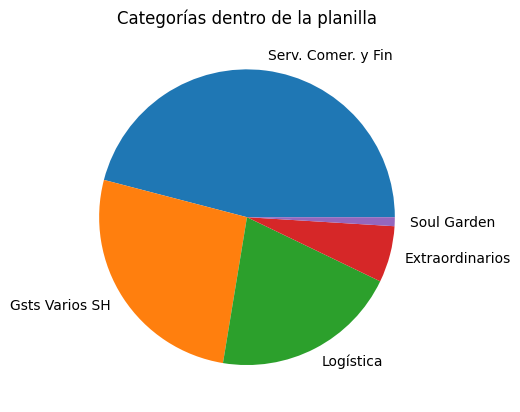

,count
categoría,
Serv. Comer. y Fin,283
Gsts Varios SH,163
Logística,126
Extraordinarios,38
Soul Garden,6


In [ ]:
#Presentamos la fracción de cada categoría sobre el total

plt.pie(list(planilla.categoría.value_counts()),
        labels = planilla.categoría.value_counts().index)
plt.title('Categorías dentro de la planilla')
plt.show()

planilla.categoría.value_counts()

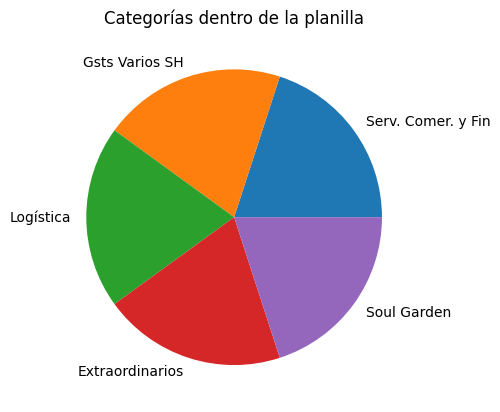

,count
categoría,
Serv. Comer. y Fin,126
Gsts Varios SH,126
Logística,126
Extraordinarios,126
Soul Garden,126


In [ ]:
#Sub y sobre muestreamos cada categoría según corresponda, definiendo como objetivo n = 126 (la mediana de entre todas las categorías)

serv = planilla.loc[planilla.categoría == 'Serv. Comer. y Fin'].sample(n=126, random_state = 42, replace = True)
gastos = planilla.loc[planilla.categoría == 'Gsts Varios SH'].sample(n=126, random_state = 42, replace = True)
log = planilla.loc[planilla.categoría == 'Logística'].sample(n=126, random_state = 42, replace = True)
extra = planilla.loc[planilla.categoría == 'Extraordinarios'].sample(n=126, random_state = 42, replace = True)
sg = planilla.loc[planilla.categoría == 'Soul Garden'].sample(n=126, random_state = 42, replace = True)

planilla = pd.concat([serv, gastos, log, extra, sg], axis = 0).sort_values(by = 'fecha').reset_index(drop = True)

plt.pie(list(planilla.categoría.value_counts()),
        labels = planilla.categoría.value_counts().index)
plt.title('Categorías dentro de la planilla')
plt.show()

planilla.categoría.value_counts()

In [ ]:
#Eliminamos los signos de puntuación

signos = list(string.punctuation) #signos de puntuación
reemplazos = ['']*len(signos)
diccionario_reemplazos = {signo:reemplazo for (signo, reemplazo) in zip(signos, reemplazos)} #diccionario para reemplazar los signos

codificación = str.maketrans(diccionario_reemplazos)
nuevos_conceptos = [texto.translate(codificación) for texto in planilla.concepto] #ejecutamos el reemplazo
planilla.concepto = nuevos_conceptos #creamos la nueva planilla con los reemplazos

---
# **Construcción y entrenamiento de los modelos**

---

In [ ]:
#Construimos los vectores BoW y TF-IDF

vectorizador_bow = CountVectorizer()
vectorizador_tf = TfidfVectorizer()

#Definimos las variables

X_bow, X_tf = vectorizador_bow.fit_transform(planilla.concepto), vectorizador_tf.fit_transform(planilla.concepto)
y = planilla.categoría

#Datos train y test para modelos basados en BoW y TF-IDF

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, random_state = 42, test_size = 0.3)
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tf, y, random_state = 42, test_size = 0.3)

#Modelos y entrenamiento

modelo_bow = RandomForestClassifier()
modelo_bow.fit(X_train_bow, y_train)

modelo_tf = RandomForestClassifier()
modelo_tf.fit(X_train_tf, y_train)

RandomForestClassifier()

---
# **Presentación de la métricas y prueba del modelo**

---

In [ ]:
#Predicciones y métricas

predicción_bow = modelo_bow.predict(X_test_bow)
predicción_tf = modelo_tf.predict(X_test_tf)

from imblearn import metrics as metrics_im

print('\nMétricas Modelo BoW:')
print(classification_report(y_test, predicción_bow))
print(f'Specificity BoW: {metrics_im.specificity_score(y_test, predicción_bow, average = "weighted")}')
print('------------------------------------------------------------')
print('\nMétricas Modelo TF-IDF:')
print(classification_report(y_test, predicción_tf))
print(f'Specificity TF-IDF: {metrics_im.specificity_score(y_test, predicción_tf, average = "weighted")}')


Métricas Modelo BoW:
                    precision    recall  f1-score   support

   Extraordinarios       0.90      1.00      0.95        38
    Gsts Varios SH       0.94      1.00      0.97        33
         Logística       1.00      0.88      0.94        42
Serv. Comer. y Fin       1.00      0.97      0.99        39
       Soul Garden       1.00      1.00      1.00        37

          accuracy                           0.97       189
         macro avg       0.97      0.97      0.97       189
      weighted avg       0.97      0.97      0.97       189

Specificity BoW: 0.9924354527003533
------------------------------------------------------------

Métricas Modelo TF-IDF:
                    precision    recall  f1-score   support

   Extraordinarios       0.95      1.00      0.97        38
    Gsts Varios SH       0.92      1.00      0.96        33
         Logística       1.00      0.95      0.98        42
Serv. Comer. y Fin       1.00      0.92      0.96        39
       Soul 

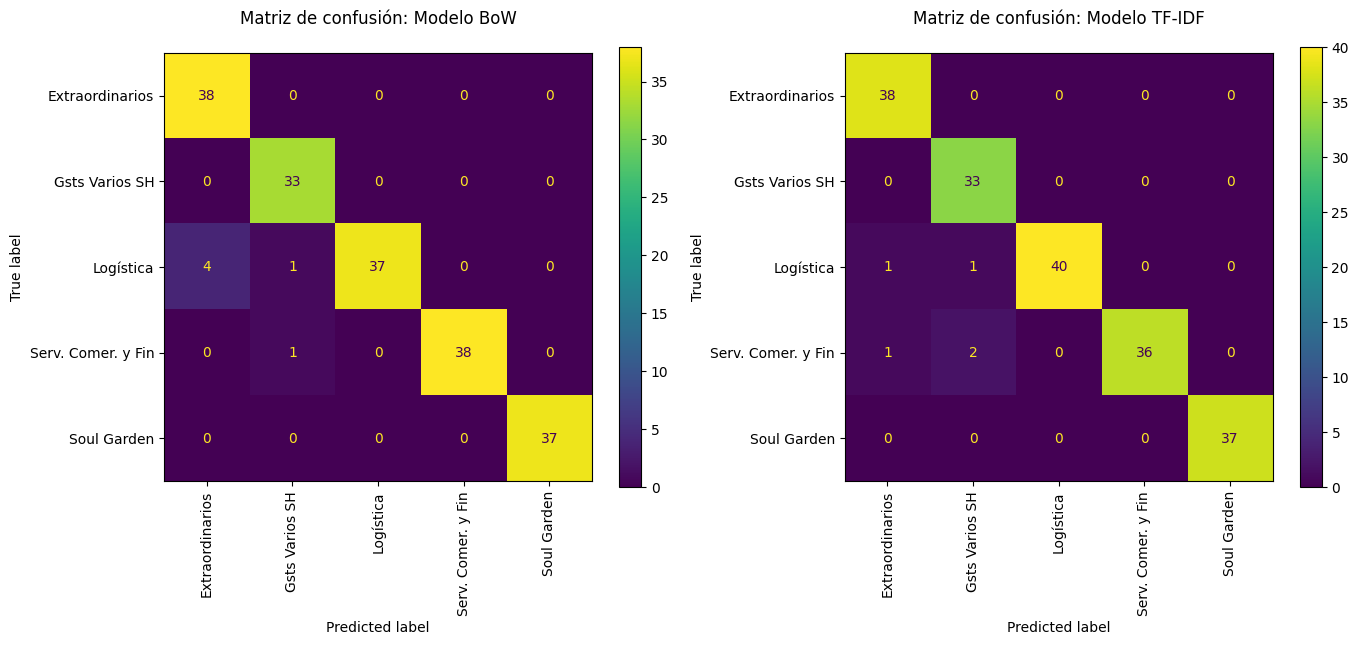

In [ ]:
#Matrices de confusión

matriz_confusión_bow = metrics.confusion_matrix(y_test, predicción_bow)
gráfica_matriz_bow = metrics.ConfusionMatrixDisplay(matriz_confusión_bow, display_labels = modelo_bow.classes_)

matriz_confusión_tf = metrics.confusion_matrix(y_test, predicción_tf)
gráfica_matriz_tf = metrics.ConfusionMatrixDisplay(matriz_confusión_tf, display_labels = modelo_tf.classes_)

fig, ax = plt.subplots(1, 2, figsize = (14,6))

gráfica_matriz_bow.plot(ax = ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
ax[0].set_title('Matriz de confusión: Modelo BoW\n')

gráfica_matriz_tf.plot(ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90)
ax[1].set_title('Matriz de confusión: Modelo TF-IDF\n')

plt.tight_layout()
plt.show()

In [ ]:
#Prueba del modelo

def prueba_modelo(texto, modelo_bow, modelo_tf, vectorizador_bow, vectorizador_tf):
  texto_bow = vectorizador_bow.transform([texto])
  texto_tf = vectorizador_tf.transform([texto])
  predicho_bow = modelo_bow.predict(texto_bow)
  predicho_tf = modelo_tf.predict(texto_tf)
  print(f'El Modelo BoW determino la categoría {predicho_bow}')
  print(f'El Modelo TF-IDF determino la categoría {predicho_tf}')

print('-------------------------------------------------------')
texto = input('Ingrese concepto:')
print('-------------------------------------------------------')

prueba_modelo(texto, modelo_bow, modelo_tf, vectorizador_bow, vectorizador_tf)

-------------------------------------------------------
Ingrese concepto:arreglo de aire acondicionado
-------------------------------------------------------
El Modelo BoW determino la categoría ['Extraordinarios']
El Modelo TF-IDF determino la categoría ['Extraordinarios']
